In [1]:
import tensorflow as tf
import tensorlayer as tl
import numpy as np
import pylab as plt

/home/jing/anaconda2/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
graph = tf.get_default_graph()
config = tf.ConfigProto()
session = tf.Session(graph=graph, config=config)

In [4]:
obs_shape = [5,160, 120,3] #should be NHWC

image = tf.placeholder(tf.float32, [None,obs_shape[0],obs_shape[1],obs_shape[2],obs_shape[3]], 'image_ph')

def keras_block(imagenetx):
    imagenet = tf.keras.layers.ConvLSTM2D(filters=16,kernel_size=[5,5],strides=[2,2],padding='same',activation=tf.nn.relu,return_sequences=True)(imagenetx)
    imagenet = tf.keras.layers.BatchNormalization()(imagenet)
    imagenet = tf.keras.layers.ConvLSTM2D(filters=32,kernel_size=[5,5],strides=[2,2],padding='same',activation=tf.nn.relu,return_sequences=True)(imagenet)
    imagenet = tf.keras.layers.BatchNormalization()(imagenet)
    imagenet = tf.keras.layers.ConvLSTM2D(filters=64,kernel_size=[3,3],strides=[2,2],padding='same',activation=tf.nn.relu,return_sequences=True)(imagenet)
    imagenet = tf.keras.layers.BatchNormalization()(imagenet)
    imagenet = tf.keras.layers.ConvLSTM2D(filters=64,kernel_size=[3,3],strides=[1,1],padding='same',activation=tf.nn.relu,return_sequences=True)(imagenet)
    imagenet = tf.keras.layers.BatchNormalization()(imagenet)
    imagenet = tf.keras.layers.Conv3D(filters=1, kernel_size=(5, 3, 3),strides=(2,1,1),activation=tf.nn.relu,padding='same')(imagenet)
    imagenet = tf.keras.layers.Conv3D(filters=1, kernel_size=(3, 3, 3),strides=(3,1,1),activation=tf.nn.relu,padding='same')(imagenet)
    return imagenet

imagenet = tl.layers.InputLayer(image, name='image_input')
imagenet = tl.layers.LambdaLayer(imagenet, fn=keras_block, name='kerasImage')
imagenet = tl.layers.FlattenLayer(imagenet, name='imagefl')
imagenet = tl.layers.DenseLayer(imagenet, n_units=960, act=tf.nn.relu, name='image_output')
image_output = imagenet.outputs

[TL] InputLayer  image_input: (?, 5, 160, 120, 3)
[TL] LambdaLayer  kerasImage
(?, 1, 20, 15, 1)


In [15]:
def generate_movies(n_samples=1000, n_frames=15):
    row = 120
    col = 160
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(0, 160)
            ystart = np.random.randint(0, 120)
            # Direction of motion
            directionx = np.random.randint(0, 20) - 1
            directiony = np.random.randint(10, 20) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 0:120, 0:160, ::]
    shifted_movies = shifted_movies[::, ::, 0:120, 0:160, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

noisy_movies, shifted_movies = generate_movies(n_samples=1000)

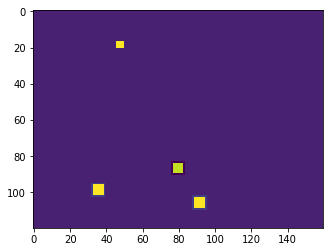

In [22]:
noisy_movies.shape
toplot = noisy_movies[0][0, ::, ::, 0]
toplot.shape
plt.imshow(toplot)